## Введение. Постановка целей и задач

----------------

В марте 2020 г. Всемирная организация здравоохранения объявила пандемию вируса SARS-CoV-2 2019 (COVID-19). Пандемия оказала большое влияние на глобальную экономику, здравоохранение и глобализацию. На глобальном уровне необходимо отслеживать текущую нагрузку и прогнозировать скорость и характер распространения, чтобы направлять осведомленность в области здравоохранения, готовность применить ответные меры. Прогнозирование является одним из ключевых элементов моделирования пандемии.

Целью исследования является анализ и прогноз динамики пандемии COVID-19, на основе статистических данных о заболеваемости в Мексике.
Для достижения поставленной цели необходимо решение следующих задач:

- провести анализ данных о распространении COVID-19;
- подтвердить или опровергнуть зависимость между новыми случаями заболевания и количеством вакцинированных;
- построить прогнозные модели новых случаев заболевания;
- оценить эффективность предложенных моделей прогнозирования.

## Импорт библиотек, ознакомление с данными

---------------

### Импорт Датафрейма, библиотек, написание функций
------------------

In [34]:
# загружаем pmdarima
!pip install pmdarima

In [35]:
# загружаем fbprophet
!pip install fbprophet

In [36]:
## Здесь импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [37]:
## Здесь импортируем данные
#url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#df = pd.read_csv(url)
df = pd.read_csv('owid-covid-data.csv')

In [38]:
## Проверяем, что все выгрузилось корректно
df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Загруженный файл .csv содержит  информацию по странам и некие количественные показатели. 

### Знакомство с данными
-------------------------

   #При помощи функции df.info() мы можем описать файл.#

 Объект состоит из 66 колонок и 149484 строк, из них 64 колонки с числовым значением и 4 колонки с текстовыми или смешанными числовыми и нечисловыми значениями. 
  - location -  географическое положение;
  - date - дата наблюдения; 
  - new_cases - новые случаи заболевания;
  - total_cases - случаи заболевания с нарастающим значением;
  - new_vaccinations - введены новые дозы вакцинации против COVID-19;
  - people_fully_vaccinated - общее количество людей, получивших все дозы, предписанные протоколом вакцинации.
  
---

In [39]:
# смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149484 entries, 0 to 149483
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149484 non-null  object 
 1   continent                                   140464 non-null  object 
 2   location                                    149484 non-null  object 
 3   date                                        149484 non-null  object 
 4   total_cases                                 146874 non-null  float64
 5   new_cases                                   146868 non-null  float64
 6   new_cases_smoothed                          145723 non-null  float64
 7   total_deaths                                129842 non-null  float64
 8   new_deaths                                  130037 non-null  float64
 9   new_deaths_smoothed                         145723 non-null  float64
 

In [40]:
# смотрим список доступных стран и выбираем себе страну
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

---
Выбираем страну исследования 'Mexico'





---

### Предобработка данных


#### Фильтрация данных

---
Для дальнейшего анализа и прогноза заболеваимости в Мексике необходимо отфильтровать данные.
Фильтруем данные по условию 'location'== Mexico и выводим необходимые для анализа данные:
  - 'location' 
  - 'date'
  - 'new_cases' 
  - 'total_cases' 
  - 'people_vaccinated' 
  - 'people_fully_vaccinated' 
  
---


In [41]:
df_new = df[df['location'].str.contains('Mexico')][['location','date','new_cases','total_cases','new_vaccinations','people_fully_vaccinated']]

In [42]:
# проверяем
df_new.head()
#df_new

,location,date,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
88177,Mexico,2020-01-01,NaN,NaN,NaN,NaN
88178,Mexico,2020-01-02,NaN,NaN,NaN,NaN
88179,Mexico,2020-01-03,NaN,NaN,NaN,NaN
88180,Mexico,2020-01-04,NaN,NaN,NaN,NaN
88181,Mexico,2020-01-05,NaN,NaN,NaN,NaN


#### Обработка пропусков


---


In [43]:
#проверяем и подсчитываем количество значений NaN
df_new.isna().sum() 

location                     0
date                         0
new_cases                   58
total_cases                 58
new_vaccinations           438
people_fully_vaccinated    432
dtype: int64

In [44]:
#заменяем значения NaN на 0
df_new = df_new.fillna(0)

In [45]:
#проверка NaN
df_new.isna().sum() 

location                   0
date                       0
new_cases                  0
total_cases                0
new_vaccinations           0
people_fully_vaccinated    0
dtype: int64

In [46]:
# проверим тип данных
df_new.dtypes

location                    object
date                        object
new_cases                  float64
total_cases                float64
new_vaccinations           float64
people_fully_vaccinated    float64
dtype: object

In [47]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [48]:
# проверим тип данных
df_new.dtypes

location                           string
date                       datetime64[ns]
new_cases                         float64
total_cases                       float64
new_vaccinations                  float64
people_fully_vaccinated           float64
dtype: object

### Вывод по этапу

---
Для дальнейшего анализа и моделирования прогноза необходимо отфильтровать проверить, при необходимости  преобразовать данные.

В ходе проверки пропусков  выявлены значения 'NaN' в  данных о численности:
  - новые случаи заболевания - 58
  - случаи заболевания с нарастающим значением - 58
  - введены новые дозы вакцинации против COVID-19 - 436
  - общее количество вакцинированных -  430
  
  
  
  Вероятно в начале пандемии статистика о вакцинированных и заболевших не велась и отсутствие данных допустимо. 

Для заполнения пробела в данных применена функция df_new.fillna(0), устранили разрыв данных заменили значения на 0.0.

При проверке типов данных выявлен не соответствие типа данных колонок 'location' и 'date' приобразуем 'location' - string, 'date' - datetime64.

---

## EDA (exploratory data analysis) или разведочный анализ данных.

---


Разведочный анализ данных (Exploratory Data Analysis) – предварительное исследование датасета с целью определения его основных характеристик, взаимосвязей между признаками.



In [49]:
# создаем столбец с датами индексом
df_new.index = df_new.date

In [50]:
# Смотрим размер выборки
len(df_new)

723

In [51]:
# Входная выборка для анализа
df_new.head()

,location,date,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
date,,,,,,
2020-01-01,Mexico,2020-01-01,0.0,0.0,0.0,0.0
2020-01-02,Mexico,2020-01-02,0.0,0.0,0.0,0.0
2020-01-03,Mexico,2020-01-03,0.0,0.0,0.0,0.0
2020-01-04,Mexico,2020-01-04,0.0,0.0,0.0,0.0
2020-01-05,Mexico,2020-01-05,0.0,0.0,0.0,0.0


In [52]:
# Проведем расчет основных статистических метрик
df_new.describe()

,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
count,723.000000,7.230000e+02,7.230000e+02,7.230000e+02
mean,5450.070539,1.584523e+06,1.692505e+05,9.429360e+06
std,5381.233439,1.340548e+06,4.466889e+05,1.787154e+07
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1442.500000,2.233730e+05,0.000000e+00,0.000000e+00
50%,4448.000000,1.383434e+06,0.000000e+00,0.000000e+00
75%,6763.000000,2.500882e+06,2.080005e+05,1.175234e+07
max,32244.000000,3.940401e+06,7.246123e+06,7.264992e+07


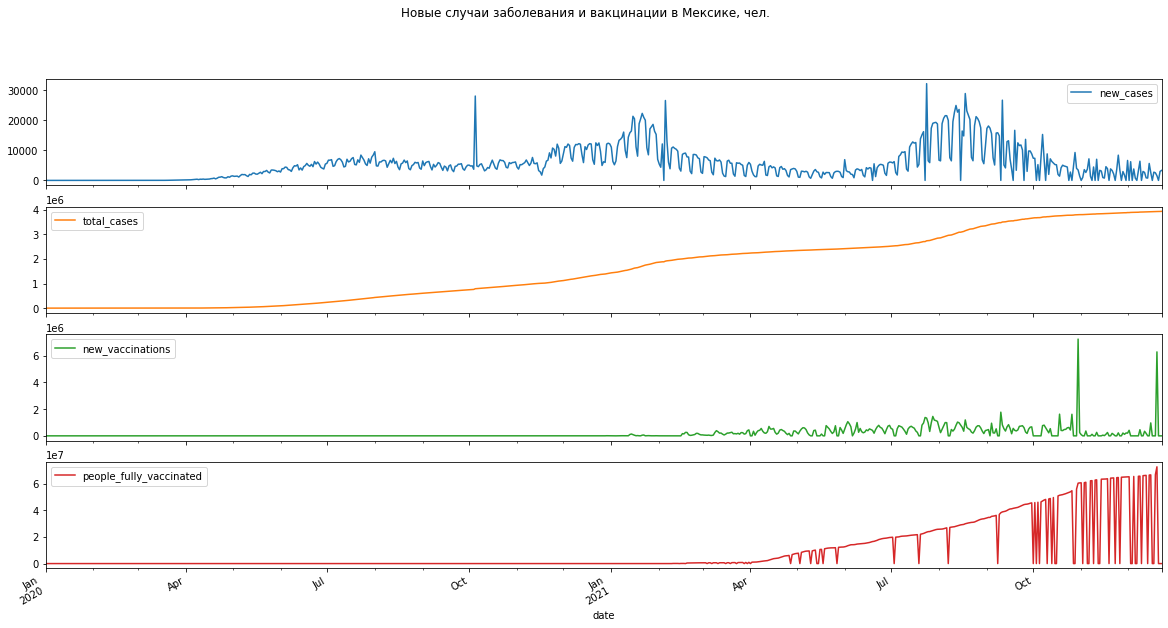

In [53]:
title = 'Новые случаи заболевания и вакцинации в Мексике, чел.'
ylabel = 'Количество, чел.'
xlabel = 'Дата'
ax=df_new[['new_cases','total_cases','new_vaccinations','people_fully_vaccinated']].plot(subplots=True,figsize=(20,10),title=title)
#ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.set_title(title,pad=20, fontdict={'fontsize':24})

--------
Промежуточный вывод

Анализируемый период с 2020-01-01 по 2021-12-23 за период пандемии общее число заболевших в Мексике составляет 3 940 401 чел.  Максимальная численность выявленных заболевших 32 244 чел. за сутки,  пиковый выброс заболеваимости приходиться на июль - август 2021 года. С октября 2021 г. отмечается снижение уровня заболеваимости, в то же время отмечается  с пик вакцинации населения приходящий на данный период. Вместе с тем общее количество заболевших выходит на плато.  Прошедших все этапы вакцинирования за время пандемии составило - 7246123  чел., что составляет 55% от общей численности населения страны.

---

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5aebdcd9d0>,
      dtype=object)

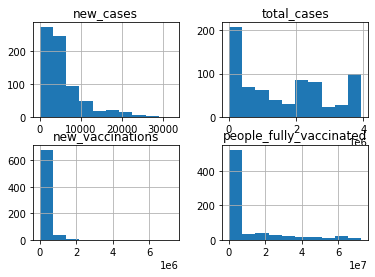

In [54]:
df_hist=df_new[['new_cases','total_cases','new_vaccinations','people_fully_vaccinated']]
df_hist.hist()

---
Промежуточный вывод:

Анализ представленного ненормального распределения позволяет сделать вывод о пиковых нагрузках в период пандемии. Это отчетливо видно на общем графике. 

---

In [55]:
# построим матрицу корреляции признаков
df_corr=df_new.corr()
cm = sns.light_palette("steelblue", as_cmap=True)
df_corr.style.background_gradient(cmap=cm)

,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
new_cases,1.000000,0.295854,0.187410,0.137811
total_cases,0.295854,1.000000,0.402635,0.716544
new_vaccinations,0.187410,0.402635,1.000000,0.437865
people_fully_vaccinated,0.137811,0.716544,0.437865,1.000000


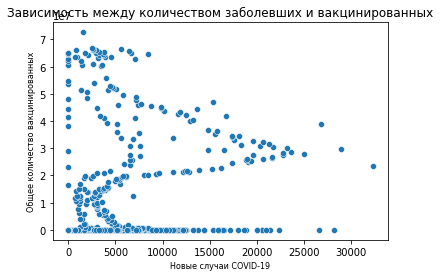

In [56]:
plt.title('Зависимость между количеством заболевших и вакцинированных',size=12)
plt.xlabel('Новые случаи COVID-19',size=8)
plt.ylabel('Общее количество вакцинированных',size=8)
sns.scatterplot(x='new_cases', y='people_fully_vaccinated', data=df_new)
plt.show()

---
Промежуточный вывод:



На коэффициент корреляции оказывает влияние нулевых показателей, напомним что по исследуемым данным выявлено множество отсутствующих значений. По данным матрицы величина корреляции между новыми случаями заболевания и общим числом вакцинированных составляет 0,1. Оба показателя линейно независимы друг от друга, что так же можно отметить на графике. Гипотеза о зависимости новых случаев заболевания и общим числом вакцинированных не подтверждена.

Можно отметить средний уровень корреляции между общим количеством заболевших и общим количеством вакцинированных 0,71, данная взаимосвязь не значимая, что говорит о разных факторах влияния на два показателя.


---

In [57]:
# при снижении новых случаев заболеваний кол-во смертей выходит на плато
#sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
#sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

## Построение моделей, анализ результатов

-------





### Обучающая и контрольная выборки

In [58]:
# выделяем выборки, где тестовая размера 10 дней
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [59]:
#посмотрим на обучающую выборку
#train.head()
train

,location,date,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
date,,,,,,
2020-01-01,Mexico,2020-01-01,0.0,0.0,0.0,0.0
2020-01-02,Mexico,2020-01-02,0.0,0.0,0.0,0.0
2020-01-03,Mexico,2020-01-03,0.0,0.0,0.0,0.0
2020-01-04,Mexico,2020-01-04,0.0,0.0,0.0,0.0
2020-01-05,Mexico,2020-01-05,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-12-09,Mexico,2021-12-09,6395.0,3911714.0,459229.0,65630611.0
2021-12-10,Mexico,2021-12-10,0.0,3911714.0,0.0,0.0
2021-12-11,Mexico,2021-12-11,2992.0,3914706.0,0.0,66003384.0


In [60]:
#посмотрим на тестовую выборку
#train.head()
test

,location,date,new_cases,total_cases,new_vaccinations,people_fully_vaccinated
date,,,,,,
2021-12-14,Mexico,2021-12-14,771.0,3918987.0,0.0,0.0
2021-12-15,Mexico,2021-12-15,5651.0,3924638.0,0.0,66459570.0
2021-12-16,Mexico,2021-12-16,2627.0,3927265.0,968736.0,66586509.0
2021-12-17,Mexico,2021-12-17,0.0,3927265.0,0.0,0.0
2021-12-18,Mexico,2021-12-18,2750.0,3930015.0,0.0,0.0
2021-12-19,Mexico,2021-12-19,2530.0,3932545.0,0.0,66740075.0
2021-12-20,Mexico,2021-12-20,1557.0,3934102.0,6287242.0,72649923.0
2021-12-21,Mexico,2021-12-21,0.0,3934102.0,0.0,0.0
2021-12-22,Mexico,2021-12-22,2980.0,3937082.0,0.0,0.0


### ETS декомпозиция

ETS расшифровывается как Error-Trend-Seasonality и представляет собой модель, используемую для декомпозиции временных рядов. Он разбивает ряд на составляющие ошибки, тренда и сезонности. Это одномерная модель прогнозирования, используемая при работе с данными временных рядов. Основное внимание уделяется трендовой и сезонной составляющим. Эта модель состоит из различных концепций, таких как модель методов тренда, экспоненциальное сглаживание и разложение ETS.
Это помогает в создании модели, соответствующей данным, с использованием трех ключевых факторов: ошибки, тренда и сезонности. В модели ETS эти термины будут использоваться для «сглаживания».

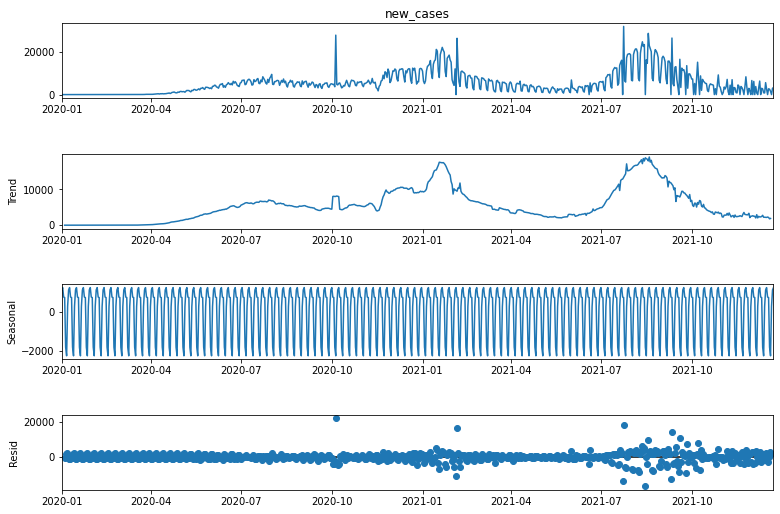

In [61]:
r = seasonal_decompose(df_new['new_cases'],model='additive')
F = r.plot()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) 
plt.show()

---
Промежуточный вывод:

Пиковое значение приходиться на июль 2021 г., наблюдается недельная сезонность.

---

## Построение моделей

---------------------



### Метод прогнозирования - SARIMAX

Описание модели


-----------

SARIMAX - сезонная авторегрессионная интегрированная скользящая средняя с экзогенными регрессорами. 

Основой данной модели является авторегрессионное интегрированное скользящее среднее или ARIMA  - метод прогнозирования для одномерных данных временных рядов,поддерживает элементы авторегрессии и скользящего среднего. 

Интегрированный элемент относится к разнице, позволяющей методу поддерживать данные временных рядов с помощью тренда.Это временной ряд с повторяющимся циклом.

ARIMA ожидает данные, которые не являются сезонными или сезонный компонент удален, например, сезонно корректируется с помощью таких методов, как сезонное различие.


Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

Он добавляет три новых гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.

Сезонная модель ARIMA формируется путем включения дополнительных сезонных терминов в ARIMA. Сезонная часть модели состоит из терминов, которые очень похожи на несезонные компоненты модели, но включают обратные сдвиги сезонного периода.


Элементы тренда

Есть три элемента тренда, которые требуют настройки.

Они такие же, как модель ARIMA, в частности:

**p:** Порядок авторегрессии тренда.

**d:** Порядок изменения тренда.

**q:** Тренд скользящей средней.

Сезонные элементы

Есть четыре сезонных элемента, которые не являются частью ARIMA, которые должны быть настроены:

**P:** Сезонный порядок авторегрессии.

**D:** Порядок сезонных разниц.

**Q:** Сезонный порядок скользящих средних.

**m:** Количество временных шагов за один сезонный период.

Вместе обозначение для модели SARIMA задается как:**SARIMA(p,d,q)(P,D,Q)m**

Важно отметить, что m параметр влияет на P,D, а также Q параметры. Например, m = 12 для месячных данных предполагает годовой сезонный цикл.

Реализация называется SARIMAX вместо SARIMA, потому что добавление «X» к имени метода означает, что реализация также поддерживает экзогенные переменные.

Это параллельные временные ряды, которые не моделируются напрямую с помощью процессов AR, I или MA, но становятся доступными в качестве взвешенного ввода для модели.

In [62]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() #включаем сезонность и указываем период сезонности = 1 неделя

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  723
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -6751.855
Date:                             Sun, 26 Dec 2021   AIC                          13515.710
Time:                                     08:20:57   BIC                          13543.203
Sample:                                          0   HQIC                         13526.323
                                             - 723                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8149      0.067    -12.211      0.000      -0.946      -0.684
ma.L1         -0.1259      0.075     -1.683      0.092      -0.272       0.021
ma.L2         -0.6063      0.069     -8.771      0.000      -0.742      -0.471
ar.S.L7        0.8770      0.019     46.841      0.000       0.840       0.914
ma.S.L7       -0.5436      0.029    -18.808      0.000      -0.600      -0.487
sigma2      7.727e+06   1.41e+05     54.607      0.000    7.45e+06       8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):             10368.21
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              57.37   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---
Промежуточные выводы:

Оптимальная модель предложенная auto_arima SARIMAX(1, 1, 2)x(1, 0, 1, 7)

---

In [98]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['new_cases'],order=(1, 1, 2), seasonal_order=(1, 0, 1, 7))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  713
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -6664.609
Date:                             Sun, 26 Dec 2021   AIC                          13341.218
Time:                                     08:26:37   BIC                          13368.626
Sample:                                 01-01-2020   HQIC                         13351.804
                                      - 12-13-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6774      0.085      7.985      0.000       0.511       0.844
ma.L1         -1.6194      0.081    -20.103      0.000      -1.777      -1.462
ma.L2          0.6862      0.068     10.113      0.000       0.553       0.819
ar.S.L7        0.9022      0.017     51.786      0.000       0.868       0.936
ma.S.L7       -0.6365      0.030    -21.326      0.000      -0.695      -0.578
sigma2      7.906e+06   9.41e-09    8.4e+14      0.000    7.91e+06    7.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):             10066.74
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              56.17   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+30. Standard errors may be unstable.
"""

In [99]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 7)	')

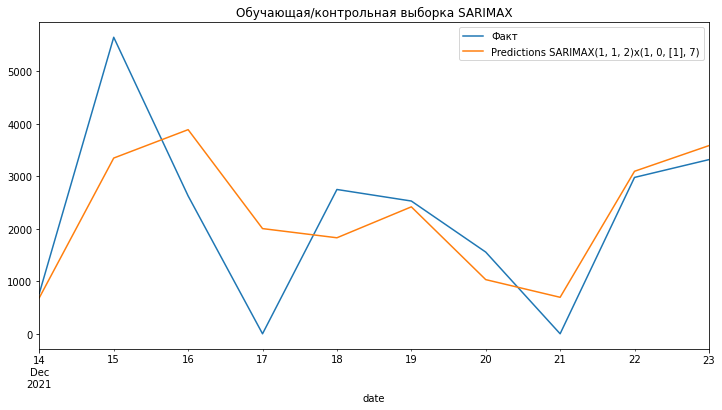

In [100]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Обучающая/контрольная выборка SARIMAX')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 7)"]);

In [101]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error_1 = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error_1 = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error_1 = rmse(test['new_cases'], prediction_sarimax)
mape_error_1 = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 7) MAPE Error: {mape_error_1:11.10}')
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 7) MAE Error: {mae_error_1:11.10}')
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 7) MSE Error: {mse_error_1:11.10}')
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 7) RMSE Error: {rmse_error_1:11.10}')


SARIMAX(1, 1, 2)x(1, 0, [1], 7) MAPE Error:         inf
SARIMAX(1, 1, 2)x(1, 0, [1], 7) MAE Error: 828.9008889
SARIMAX(1, 1, 2)x(1, 0, [1], 7) MSE Error: 1262404.078
SARIMAX(1, 1, 2)x(1, 0, [1], 7) RMSE Error: 1123.567567


#### Оценка метрик 
------------------
Для данной прогнозной модели  MAPE вывел некорректное значение, это связанно с тем, что фактические значения временного ряда близки к 0 и для оценки необходимо применить другие метрики. 

MAE Error: 828, что составляет ~13% ошибок от тестовой выборки.

MSE Error: 1 262 404  физического смысла MSE не имеет, но чем ближе к нулю, тем модель лучше.

RMSE Error:  1123 относительно максимального значения (32 тыс. чел) новых случаев заражения  составляет ~4% и относительно максимального значения тестовой выборки  ~18%




In [102]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(1, 1, 2), seasonal_order=(1, 0, [1], 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  723
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -6751.855
Date:                             Sun, 26 Dec 2021   AIC                          13515.710
Time:                                     08:26:47   BIC                          13543.203
Sample:                                 01-01-2020   HQIC                         13526.323
                                      - 12-23-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8149      0.067    -12.211      0.000      -0.946      -0.684
ma.L1         -0.1259      0.075     -1.683      0.092      -0.272       0.021
ma.L2         -0.6063      0.069     -8.771      0.000      -0.742      -0.471
ar.S.L7        0.8770      0.019     46.841      0.000       0.840       0.914
ma.S.L7       -0.5436      0.029    -18.808      0.000      -0.600      -0.487
sigma2      7.727e+06   1.41e+05     54.607      0.000    7.45e+06       8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):             10368.21
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              57.37   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

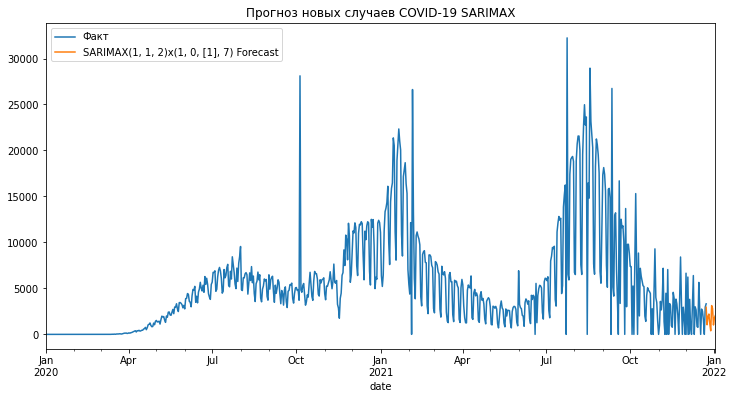

In [103]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(1, 1, 2)x(1, 0, [1], 7) Forecast')

#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 SARIMAX') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "SARIMAX(1, 1, 2)x(1, 0, [1], 7) Forecast"])

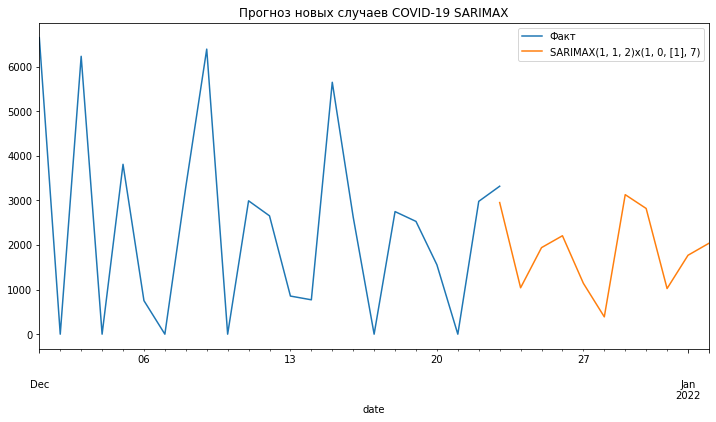

In [104]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(1, 1, 2)x(1, 0, [1], 7) Forecast')

#строим график на будущее
ax = df_new['2021-12-01':]['new_cases'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 SARIMAX') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "SARIMAX(1, 1, 2)x(1, 0, [1], 7)"]);

#### Выводы работы метода SARIMAX

---
Прогнозирование временного ряда SARIMAX проводилось на интервале с 24.12.2021 до 02.01.2022 г. с обучающей выборкой  01.01.2021 - 13.01.2021 и контрольной  выборкой 14.12.2021 - 23.12.2021. 
ETS декомпозиция выявела недельную сезонность. Оптимальные параметры прогнозной модели с учетом сезонности расчитаны при помощи auto_arima - SARIMAX(1, 1, 2)x(2, 0, 2, 7).
Для данного прогноза MAE = 827 (~3%), RMSE = 1123 (4%) ошибок от максимального значения по анализируемому показателю.

---

### Метод прогнозирования - PROPHET

Описание модели


---

**Prophet** - это процедура для прогнозирования данных временных рядов на основе аддитивной модели, в которой нелинейные тенденции соответствуют годовой, еженедельной и дневной сезонности, а также праздничным эффектам. Он лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты и несколько сезонов исторических данных. Prophet устойчив к отсутствию данных и сдвигам в тренде и, как правило, хорошо справляется с выбросами.

In [105]:
# подготовим данные для модели
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [106]:
# подготовим данные по всему датасету для модели
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [107]:
# создаем модель с подобранными параметрами

model_prophet = Prophet(seasonality_mode='multiplicative') 

#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
Промежуточные выводы:

Алгоритм проигнорировал, выбирая параметры

1. `Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.`

    - годовую сезонность (*для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам*).

Зато он обнаружил недельную сезонность и использовал его при настройке модели.

---

In [108]:
# говорим профету сделать дата-фрейм на 10 дней вперед
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [109]:
##предсказываем значения по модели
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-01-01,-738.844242,-6532.010043,4565.470075,-738.844242,-738.844242,0.216154,0.216154,0.216154,0.216154,0.216154,0.216154,0.0,0.0,0.0,-898.548578
1,2020-01-02,-714.290184,-6321.666572,4742.826440,-714.290184,-714.290184,0.227624,0.227624,0.227624,0.227624,0.227624,0.227624,0.0,0.0,0.0,-876.879977
2,2020-01-03,-689.736126,-6554.450497,5049.353957,-689.736126,-689.736126,0.150856,0.150856,0.150856,0.150856,0.150856,0.150856,0.0,0.0,0.0,-793.787198
3,2020-01-04,-665.182068,-7025.115853,4518.875448,-665.182068,-665.182068,0.144121,0.144121,0.144121,0.144121,0.144121,0.144121,0.0,0.0,0.0,-761.048573
4,2020-01-05,-640.628010,-6058.564175,5126.149340,-640.628010,-640.628010,-0.360066,-0.360066,-0.360066,-0.360066,-0.360066,-0.360066,0.0,0.0,0.0,-409.959463


In [110]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-01,2020-01-01,-738.844242,-6532.010043,4565.470075,-738.844242,-738.844242,0.216154,0.216154,0.216154,0.216154,0.216154,0.216154,0.0,0.0,0.0,-898.548578
2020-01-02,2020-01-02,-714.290184,-6321.666572,4742.826440,-714.290184,-714.290184,0.227624,0.227624,0.227624,0.227624,0.227624,0.227624,0.0,0.0,0.0,-876.879977
2020-01-03,2020-01-03,-689.736126,-6554.450497,5049.353957,-689.736126,-689.736126,0.150856,0.150856,0.150856,0.150856,0.150856,0.150856,0.0,0.0,0.0,-793.787198
2020-01-04,2020-01-04,-665.182068,-7025.115853,4518.875448,-665.182068,-665.182068,0.144121,0.144121,0.144121,0.144121,0.144121,0.144121,0.0,0.0,0.0,-761.048573
2020-01-05,2020-01-05,-640.628010,-6058.564175,5126.149340,-640.628010,-640.628010,-0.360066,-0.360066,-0.360066,-0.360066,-0.360066,-0.360066,0.0,0.0,0.0,-409.959463


In [111]:
prediction_prophet[['ds', 'yhat']] # оставим только нужные

,ds,yhat
ds,,
2020-01-01,2020-01-01,-898.548578
2020-01-02,2020-01-02,-876.879977
2020-01-03,2020-01-03,-793.787198
2020-01-04,2020-01-04,-761.048573
2020-01-05,2020-01-05,-409.959463
...,...,...
2021-12-19,2021-12-19,3532.042710
2021-12-20,2021-12-20,3065.823922
2021-12-21,2021-12-21,5844.290826


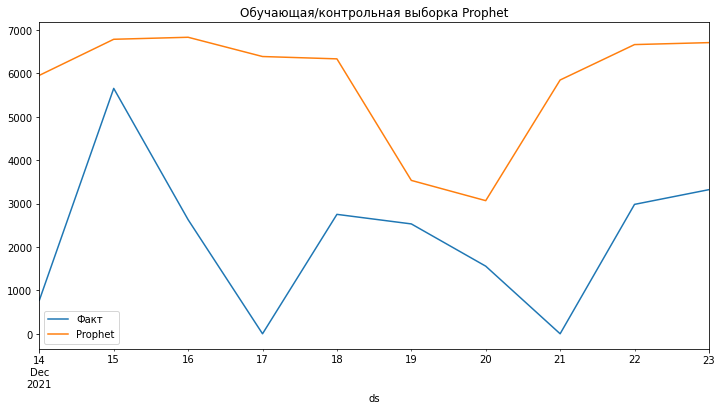

In [112]:
ax = (df_new_prophet['2021-12-14':][['ds', 'y']].plot(x='ds',y='y',figsize=(12,6),title='Обучающая/контрольная выборка Prophet'))
prediction_prophet['2021-12-14':].plot(x='ds',y='yhat',figsize=(12,6), ax=ax)
ax.legend(["Факт", "Prophet"]);

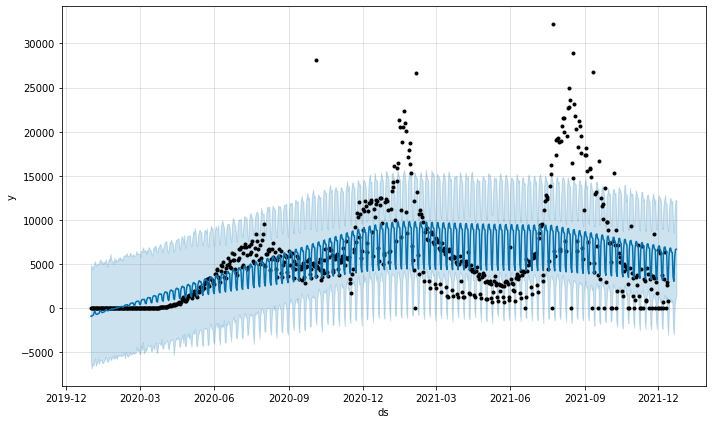

In [78]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet);

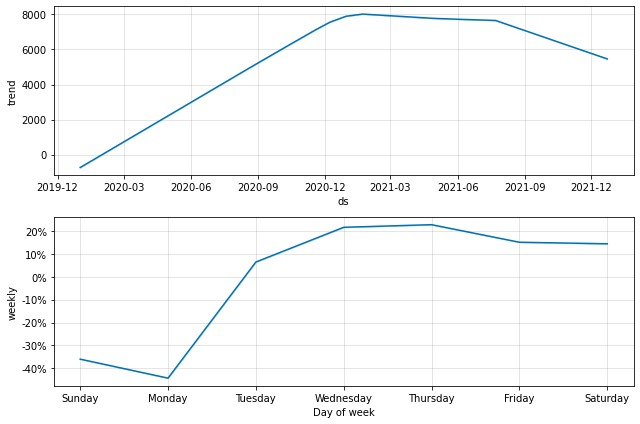

In [113]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

In [114]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error_2 = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error_2 = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error_2 = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error_2 = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAPE Error: {mape_error_2:11.10}')
print(f'Prophet MAE Error: {mae_error_2:11.10}')
print(f'Prophet MSE Error: {mse_error_2:11.10}')
print(f'Prophet RMSE Error: {rmse_error_2:11.10}')


Prophet MAPE Error:         inf
Prophet MAE Error: 3590.079981
Prophet MSE Error: 16180765.15
Prophet RMSE Error: 4022.532181


#### Оценка метрик 
----------------

Для данной прогнозной модели  MAPE вывел некорректное значение.

MAE Error: 3590, что составляет ~59% ошибок от тестовой выборки и 11% от максимального значения дата сета.

MSE Error: 16 180 765  в нашем случае оценка далека от положительной.

RMSE Error:  4022 относительно максимального значения датасета составляет ~13%


In [115]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)

# говорим профету сделать дата-фрейм на 10 дней вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


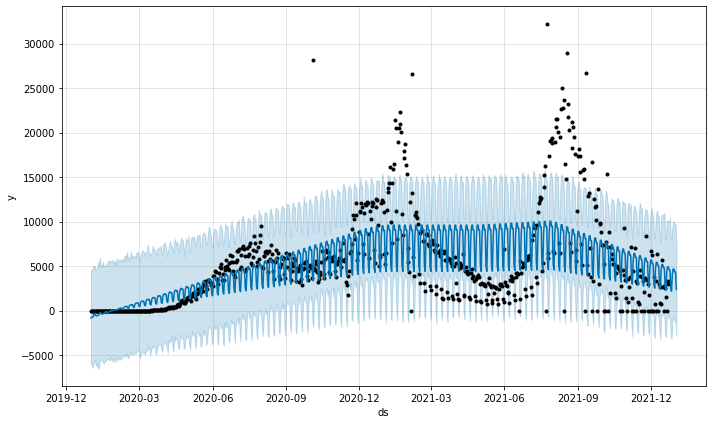

In [116]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet);

In [117]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [118]:
# убедимся в изменениях
fut_fcast_prophet#.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-01,2020-01-01,-650.313478,-5988.340323,4636.239197,-650.313478,-650.313478,0.217721,0.217721,0.217721,0.217721,0.217721,0.217721,0.0,0.0,0.0,-791.900191
2020-01-02,2020-01-02,-626.371234,-6163.737476,4374.411937,-626.371234,-626.371234,0.223647,0.223647,0.223647,0.223647,0.223647,0.223647,0.0,0.0,0.0,-766.457585
2020-01-03,2020-01-03,-602.428989,-6417.105230,4603.799392,-602.428989,-602.428989,0.147581,0.147581,0.147581,0.147581,0.147581,0.147581,0.0,0.0,0.0,-691.335875
2020-01-04,2020-01-04,-578.486745,-6024.564430,5059.660001,-578.486745,-578.486745,0.149996,0.149996,0.149996,0.149996,0.149996,0.149996,0.0,0.0,0.0,-665.257236
2020-01-05,2020-01-05,-554.544500,-5495.172187,4830.909109,-554.544500,-554.544500,-0.361926,-0.361926,-0.361926,-0.361926,-0.361926,-0.361926,0.0,0.0,0.0,-353.840324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,2021-12-29,3850.819123,-864.237782,10021.066290,3850.627810,3850.819123,0.217721,0.217721,0.217721,0.217721,0.217721,0.217721,0.0,0.0,0.0,4689.222199
2021-12-30,2021-12-30,3821.740514,-631.513058,10022.349447,3820.959867,3821.959200,0.223647,0.223647,0.223647,0.223647,0.223647,0.223647,0.0,0.0,0.0,4676.463172
2021-12-31,2021-12-31,3792.661905,-1247.300243,9705.991370,3791.055862,3793.125713,0.147581,0.147581,0.147581,0.147581,0.147581,0.147581,0.0,0.0,0.0,4352.385567


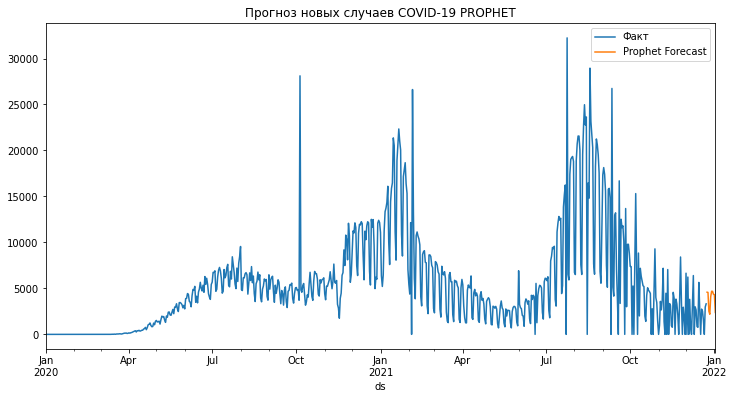

In [119]:
#строим график на будущее
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 PROPHET') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Prophet Forecast"]);

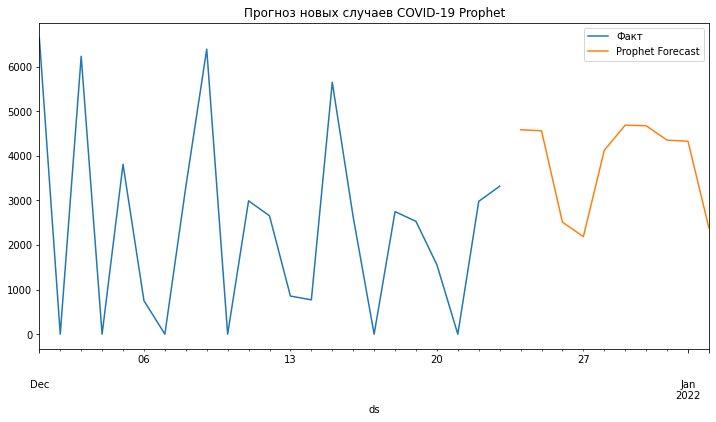

In [120]:
#строим график на будущее
ax = df_new_prophet['2021-12-01':]['y'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 Prophet') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Prophet Forecast"]);


#### Выводы работы метода PROPHET
--------------------

Прогнозирование временного ряда PROPHET проводилось на интервале с 24.12.2021 до 02.01.2022 г. с обучающей выборкой 01.01.2021 - 13.01.2021 и контрольной выборкой 14.12.2021 - 23.12.2021. Модель определила недельную сезонность и произвела расчет прогноза. 
Для данной прогнозной модели MAPE вывел некорректное значение.
MAE Error: 3591, что составляет ~11% ошибок
MSE Error: 16 405 075.06 в нашем случае оценка далека от положительной.
RMSE Error: 4050 относительно максимального значения составляет ~13%

---

### Метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

Описание модели 

---
**Экспоненциальное сглаживание** (ETS) было предложено в конце 1950-х годов (Brown, 1959 ; Holt, 1957 ; Winters, 1960 ) и послужило стимулом для некоторых из наиболее успешных методов прогнозирования. Прогнозы, полученные с использованием методов экспоненциального сглаживания, представляют собой средневзвешенные значения прошлых наблюдений, причем веса экспоненциально убывают по мере того, как наблюдения становятся старше. Другими словами, чем позже было наблюдение, тем выше связанный вес. Эта структура генерирует надежные прогнозы быстро и для широкого диапазона временных рядов, что является большим преимуществом и имеет большое значение для промышленных приложений.




---

In [121]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [122]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 0.0,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.0,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.16999999999999998,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.0001,
 'use_boxcox': False}

In [123]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [124]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-14 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [125]:
#проверим
prediction_exps#.head()

,prediction_exps
2021-12-14,2273.266937
2021-12-15,2273.456239
2021-12-16,2273.645540
2021-12-17,2273.834841
2021-12-18,2274.024143
2021-12-19,2274.213444
2021-12-20,2274.402745
2021-12-21,2274.592047
2021-12-22,2274.781348
2021-12-23,2274.970649


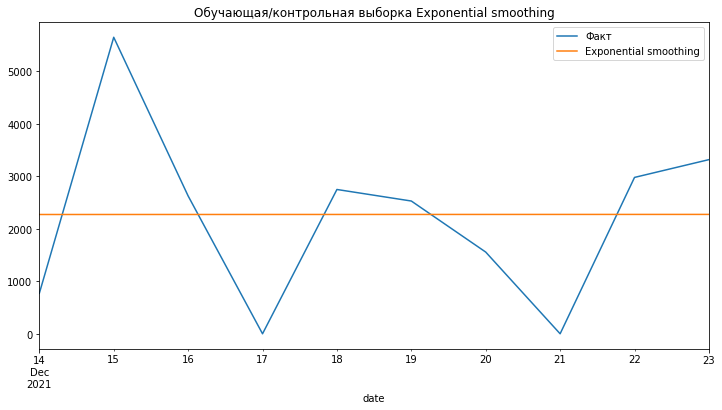

In [126]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Обучающая/контрольная выборка Exponential smoothing')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Exponential smoothing"]);

In [127]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error_3 = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error_3 = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error_3 = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error_3 = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print(f'Exponential smoothing MAPE Error: {mape_error_3:11.10}')
print(f'Exponential smoothing MAE Error: {mae_error_3:11.10}')
print(f'Exponential smoothing MSE Error: {mse_error_3:11.10}')
print(f'Exponential smoothing RMSE Error: {rmse_error_3:11.10}')

Exponential smoothing MAPE Error:         inf
Exponential smoothing MAE Error: 1298.000521
Exponential smoothing MSE Error: 2652753.816
Exponential smoothing RMSE Error: 1628.727668


####Оценка метрик
--------
Для данной прогнозной модели  MAPE вывел некорректное значение

MAE Error: 1298, что составляет ~4% ошибок от максимального значения датасета

MSE Error: 2 652 753  в нашем случае оценка далека от положительной

RMSE Error:  1628 относительно максимального значения составляет ~5% максимального значения максимального значения датасета.


In [128]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-23", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [129]:
#проверим
fut_fcast_exps#head()

,fut_fcast_exps
2021-12-23,2018.772654
2021-12-24,2239.997092
2021-12-25,2240.182880
2021-12-26,2240.368669
2021-12-27,2240.554458
2021-12-28,2240.740247
2021-12-29,2240.926036
2021-12-30,2241.111825
2021-12-31,2241.297614
2022-01-01,2241.483403


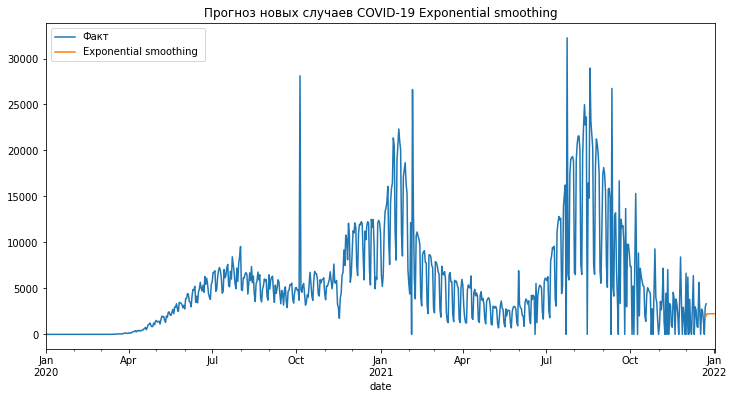

In [130]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 Exponential smoothing') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Exponential smoothing "])

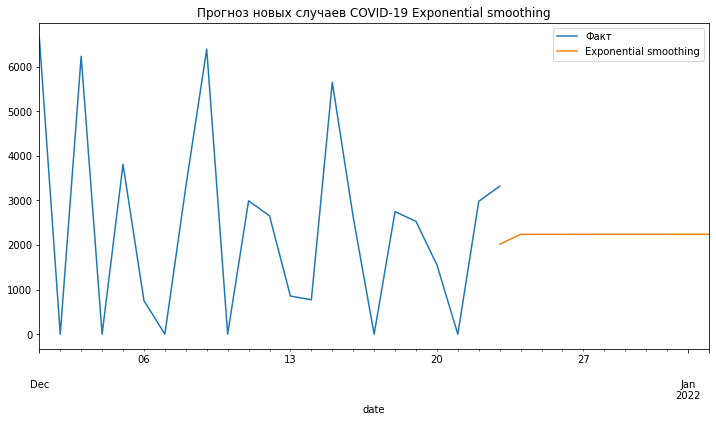

In [132]:
#строим график на будущее
ax = df_new['2021-12-01':]['new_cases'].plot(legend=True, figsize=(12,6),title='Прогноз новых случаев COVID-19 Exponential smoothing') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "Exponential smoothing"]);

#### Выводы работы метода Exponential smoothing

---
Модель подобрала оптимальные параметры. Для данной прогнозной модели MAPE вывел некорректное значение. 
Для данной прогнозной модели  MAPE вывел некорректное значение.
MAE Error: 1342, что составляет ~4% ошибок
MSE Error: 3 004 709.408 в нашем случае оценка далека от положительной
RMSE Error: 1733 относительно максимального значения составляет ~5%



---

## Вывод
---

Проведена предобработка и анализ данных о заболеваемости COVID -19  на примере Мексики с использованием современных методов обработки статистической информации. По данным анализа максимальная численность выявленных заболевших 32 244 чел. за сутки,  пиковый выброс заболеваимости приходиться на июль - август 2021 года. С октября 2021 г. отмечается снижение уровня заболеваемости, на данный период можно отметить пик вакцинации населения. 
Опровергнута гипотеза о зависимости новых случав заболевания и общей численности вакцинированных. 

Для построения прогнозной модели применены следующие методы:
- SARIMAX; 
- Prophet;
- Exponential smoothing. 

Оценка качества моделей прогнозирования новых случаев заболеваемости COVID - 19 произвели с помощью ключевых показателей - метрик. Оценки качества была определена 
- средняя абсолютная ошибка в процентах (MAPE)
- средняя абсолютная разница между предсказаниями и фактическими значениями (MAE); 
- среднеквадратичная ошибка (MSE); 
- среднеквадратичной ошибкой (RMSE).
 Данная система метрик позволит объективно оценить точность моделей на тестовой выборке и сравнить используемые методы.

Анализ контрольной и тестовой выборки производился свременным интервалом обучающей выборкой 01.01.2020 - 13.12.2021 и тестовой выборкой 14.12.2021 - 23.12.2021.(10дн.).
Видим что МАРЕ - некорректное значение inf, это связанно с тем, что фактические значения временного ряда близки к 0 и для оценки необходимо применить другие метрики. Все три модели хорошо адаптированы к недельной сезонности. Метрик  модели PROPHET оказались худшими в тесте, что подтверждается графиком. Показатели метрик SARIMAX	и ETS близки, но производительность модели SARIMAX выше. По графику видно что SARIMAX хоть и не улавливает пики, но примерно описывает график контрольных данных.

Прогнозирование временных рядов проводилось на интервале 24.12.2021 - 02.01.2022 (10дн.), с обучающей выборкой 01.01.2021-23.12.2021.

Таким образом, на основании проведенного анализа оценки качества моделей прогнозирования наиболее точным прогнозом новых случаев заболевания COVID - 19 в Мексике целесообразности считать модель построенную методом SARIMAX.

-------

In [133]:
df_tab = pd.DataFrame({'Метрика': ['MAPE', 'MAE', 'MSE','RMSE'], 'SARIMAX': [mape_error_1,mae_error_1, mse_error_1, rmse_error_1],
                       'PROPHET': [mape_error_2,mae_error_2, mse_error_2, rmse_error_2],'ES': [mape_error_3,mae_error_3, mse_error_3, rmse_error_3]})


rounded_df = df_tab.round(decimals=1)
rounded_df 

,Метрика,SARIMAX,PROPHET,ES
0,MAPE,inf,inf,inf
1,MAE,828.9,3590.1,1298.0
2,MSE,1262404.1,16180765.1,2652753.8
3,RMSE,1123.6,4022.5,1628.7


[Text(0, 0.5, ''), Text(0.5, 0, 'Дата')]

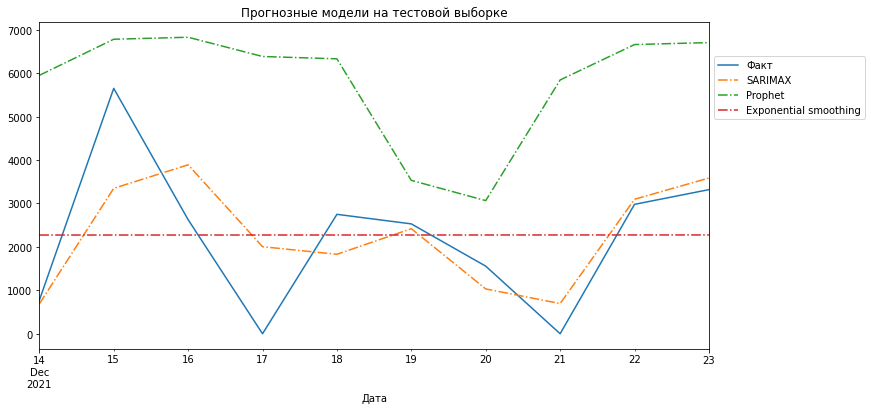

In [134]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Прогнозные модели на тестовой выборке')
prediction_sarimax.plot(legend=True,linestyle = '-.')
prediction_prophet['2021-12-14':'2021-12-23'].plot(x='ds',y='yhat',figsize=(12,6), ax=ax,linestyle = '-.')
prediction_exps['prediction_exps'].plot(legend=True,linestyle = '-.')

ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "SARIMAX", "Prophet","Exponential smoothing"],loc='center left',bbox_to_anchor=(1,0.8));
ylabel = '' 
xlabel = 'Дата' 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

[Text(0, 0.5, ''), Text(0.5, 0, 'Дата')]

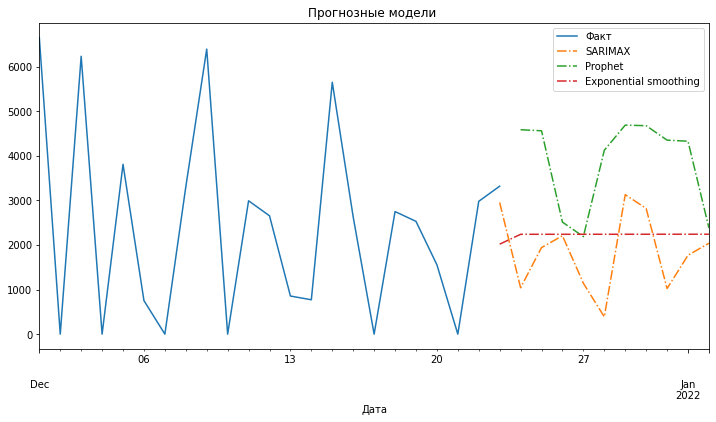

In [135]:
ax = df_new['2021-12-01':]['new_cases'].plot(legend=True, figsize=(12,6),title='Прогнозные модели ') 


fut_fcast_sarimax.plot(legend=True,linestyle = '-.')
fut_fcast_prophet['yhat'].tail(10).plot(legend=True,linestyle = '-.')
fut_fcast_exps['fut_fcast_exps'].plot(legend=True,linestyle = '-.')
ax.autoscale(axis='x',tight=True)
ax.legend(["Факт", "SARIMAX", "Prophet","Exponential smoothing"]);
ylabel = '' 
xlabel = 'Дата' 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)